## ETL with movies/series datasets from Disney and Netflix

This jupyter notebook contains the following sections:

1) EXTRACT: extract data from data lake
2) EDA: exploratory data analysis
    - a) DATA TYPES
    - b) MISSING VALUES
    - c) COMPARATIVE ANALYSIS with graphics
    - d) OUTLIERS
    - e) TEXT DATA
    - f) DUPLICATED DATA
3) TRANSFORMATION
    - a) DATA VALIDATION
    - b) RELOADING
    - c) CORRUPTED DATA INSPECTION
    - d) TRANSFORMATION
4) LOADING
5) DATA MODELLING
6) DATABASE TESTING 


In [ ]:
## For EDA
import pandas as pd
import numpy as np
import os
import glob
from io import StringIO
import json
from itertools import chain
import re

## For plotting
import matplotlib.pyplot as plt
import plotly.express as px

## For Amazon
import boto3

## For database
import pymysql
import sqlalchemy

## For missing data
import missingno as msno

#### WORDCLOUD
from wordcloud import WordCloud
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

## 1) EXTRACT: 

Extracting data from data lake (S3 bucket)

In [31]:
## List of arguments to execute the get_all_files method of S3_downloader.

list_s3_files = ['disney_plus_titles.csv', 'netflix_titles.csv']
path_in_s3 = ''

bucket_name = 'desafio-rkd'

list_names_to_save = ['disney.csv', 'netflix.csv']
path_in_local = 'data/'

with open('s3.json', 'r') as file:
    data = json.load(file)
    key = data['key']
    secret = data['secret']

In [32]:
class S3_downloader:
    #It connects to the bucket upon class creation
    #Takes the key and secret as arguments.
    def __init__(self, key, secret):
        self.s3 = boto3.client('s3', aws_access_key_id = key, aws_secret_access_key = secret)

    #Saves a file to the bucket
    #Takes the bucket name, the file name in the bucket, and the file name locally as arguments.
    def save_file(self, bucket_name, object_key, file_name):
        self.s3.download_file(bucket_name, object_key, file_name)

    #Gets a file from the bucket
    #Takes the bucket name and the file name in the bucket as arguments
    #Returns the file.
    def get_file(self, bucket_name, object_key):
        obj = self.s3.get_object(Bucket = bucket_name, Key = object_key)
        return obj['Body'].read().decode('utf-8')

    #Gets all files from a bucket
    #Takes the bucket name, the list of files in the bucket, the path in the bucket, and the path locally as arguments
    #Saves the files locally in the specified path.
    def get_all_files(self, bucket_name, list_s3, path_in_s3 = '', path_in_local = '', list_names = []):
        for file in list_s3:
            file = path_in_s3 + file
            if len(list_names) == 0:
                file_local = path_in_local + file.split('/')[-1]
                self.save_file(bucket_name, file, file_local)
            else:
                file_local = path_in_local + list_names[list_s3.index(file)]
                self.save_file(bucket_name, file, file_local)
    
    #Gets all files from a bucket
    #Takes the bucket name as an argument
    #Returns a dictionary with the names of the files.
    def check_files(self, bucket_name):
        response = self.s3.list_objects_v2(Bucket = bucket_name)
        print(response['Contents'])
        return response['Contents']

In [33]:
# Create an instance of the class
downloader = S3_downloader(key, secret)

# Get all files from the bucket
downloader.get_all_files(bucket_name, list_s3_files, path_in_s3, path_in_local, list_names_to_save)

In [34]:
# Get info about the files in the bucket
downloader.check_files(bucket_name)

## 2) EDA: 

### - a) DATA TYPES

#### DISNEY

In [35]:
disney = pd.read_csv('data/disney.csv', parse_dates=['date_added'], encoding='utf-8')
disney.index.name = 'id'
disney.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
id,,,,,,,,,,,,
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,2021-11-26,2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,2021-11-26,1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,2021-11-26,2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,2021-11-26,2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,2021-11-25,2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...


In [36]:
disney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       1450 non-null   object        
 1   type          1450 non-null   object        
 2   title         1450 non-null   object        
 3   director      977 non-null    object        
 4   cast          1260 non-null   object        
 5   country       1231 non-null   object        
 6   date_added    1447 non-null   datetime64[ns]
 7   release_year  1450 non-null   int64         
 8   rating        1447 non-null   object        
 9   duration      1450 non-null   object        
 10  listed_in     1450 non-null   object        
 11  description   1450 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 136.1+ KB


In [37]:
disney.describe(include=object)

,show_id,type,title,director,cast,country,rating,duration,listed_in,description
count,1450,1450,1450,977,1260,1231,1447,1450,1450,1450
unique,1450,2,1450,609,1193,89,9,158,329,1448
top,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,Jack Hannah,Winston Hibler,United States,TV-G,1 Season,"Animation, Comedy, Family","Cooper and Cami Wrather co-host ""Would You Wra..."
freq,1,1052,1,17,10,1005,318,219,124,2


#### NETFLIX

In [38]:
netflix = pd.read_csv('data/netflix.csv', sep=';', encoding='utf-8', parse_dates=['date_added'])
netflix.index.name = 'id'
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
id,,,,,,,,,,,,
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [39]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8809 non-null   object
 1   type          8808 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7983 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   object
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8806 non-null   object
 11  description   8806 non-null   object
dtypes: object(12)
memory usage: 826.0+ KB


In [40]:
netflix.describe(include=object)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
count,8809,8808,8807,6173,7983,7976,8797,8807,8803,8804,8806,8806
unique,8809,3,8807,4528,7693,749,1768,75,18,221,514,8774
top,s1,Movie,Dick Johnson Is Dead,Rajiv Chilaka,David Attenborough,United States,"January 1, 2020",2018,TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6131,1,19,19,2817,109,1147,3207,1793,362,4


#### First impressions:
- Data not friendly for tabular structure. Director, cast, country, and listed_in are strings separated by commas.
- Duration is in minutes or seasons, depending on whether it's a TV show or movie.
- There are issues with Netflix's data, as all of them were converted to String.

## 2) EDA: 

### - b) MISSING VALUES

In [41]:
disney_na = pd.DataFrame((disney.isna().sum()/disney.shape[0]*100).round(2), columns=['% of missing Disney'])
netflix_na = pd.DataFrame((netflix.isna().sum()/netflix.shape[0]*100).round(2), columns=['% of missing Netflix'])

missing_total = pd.concat([disney_na, netflix_na], axis=1)
missing_total

,% of missing Disney,% of missing Netflix
show_id,0.00,0.00
type,0.00,0.01
title,0.00,0.02
director,32.62,29.92
cast,13.10,9.38
country,15.10,9.46
date_added,0.21,0.14
release_year,0.00,0.02
rating,0.21,0.07
duration,0.00,0.06


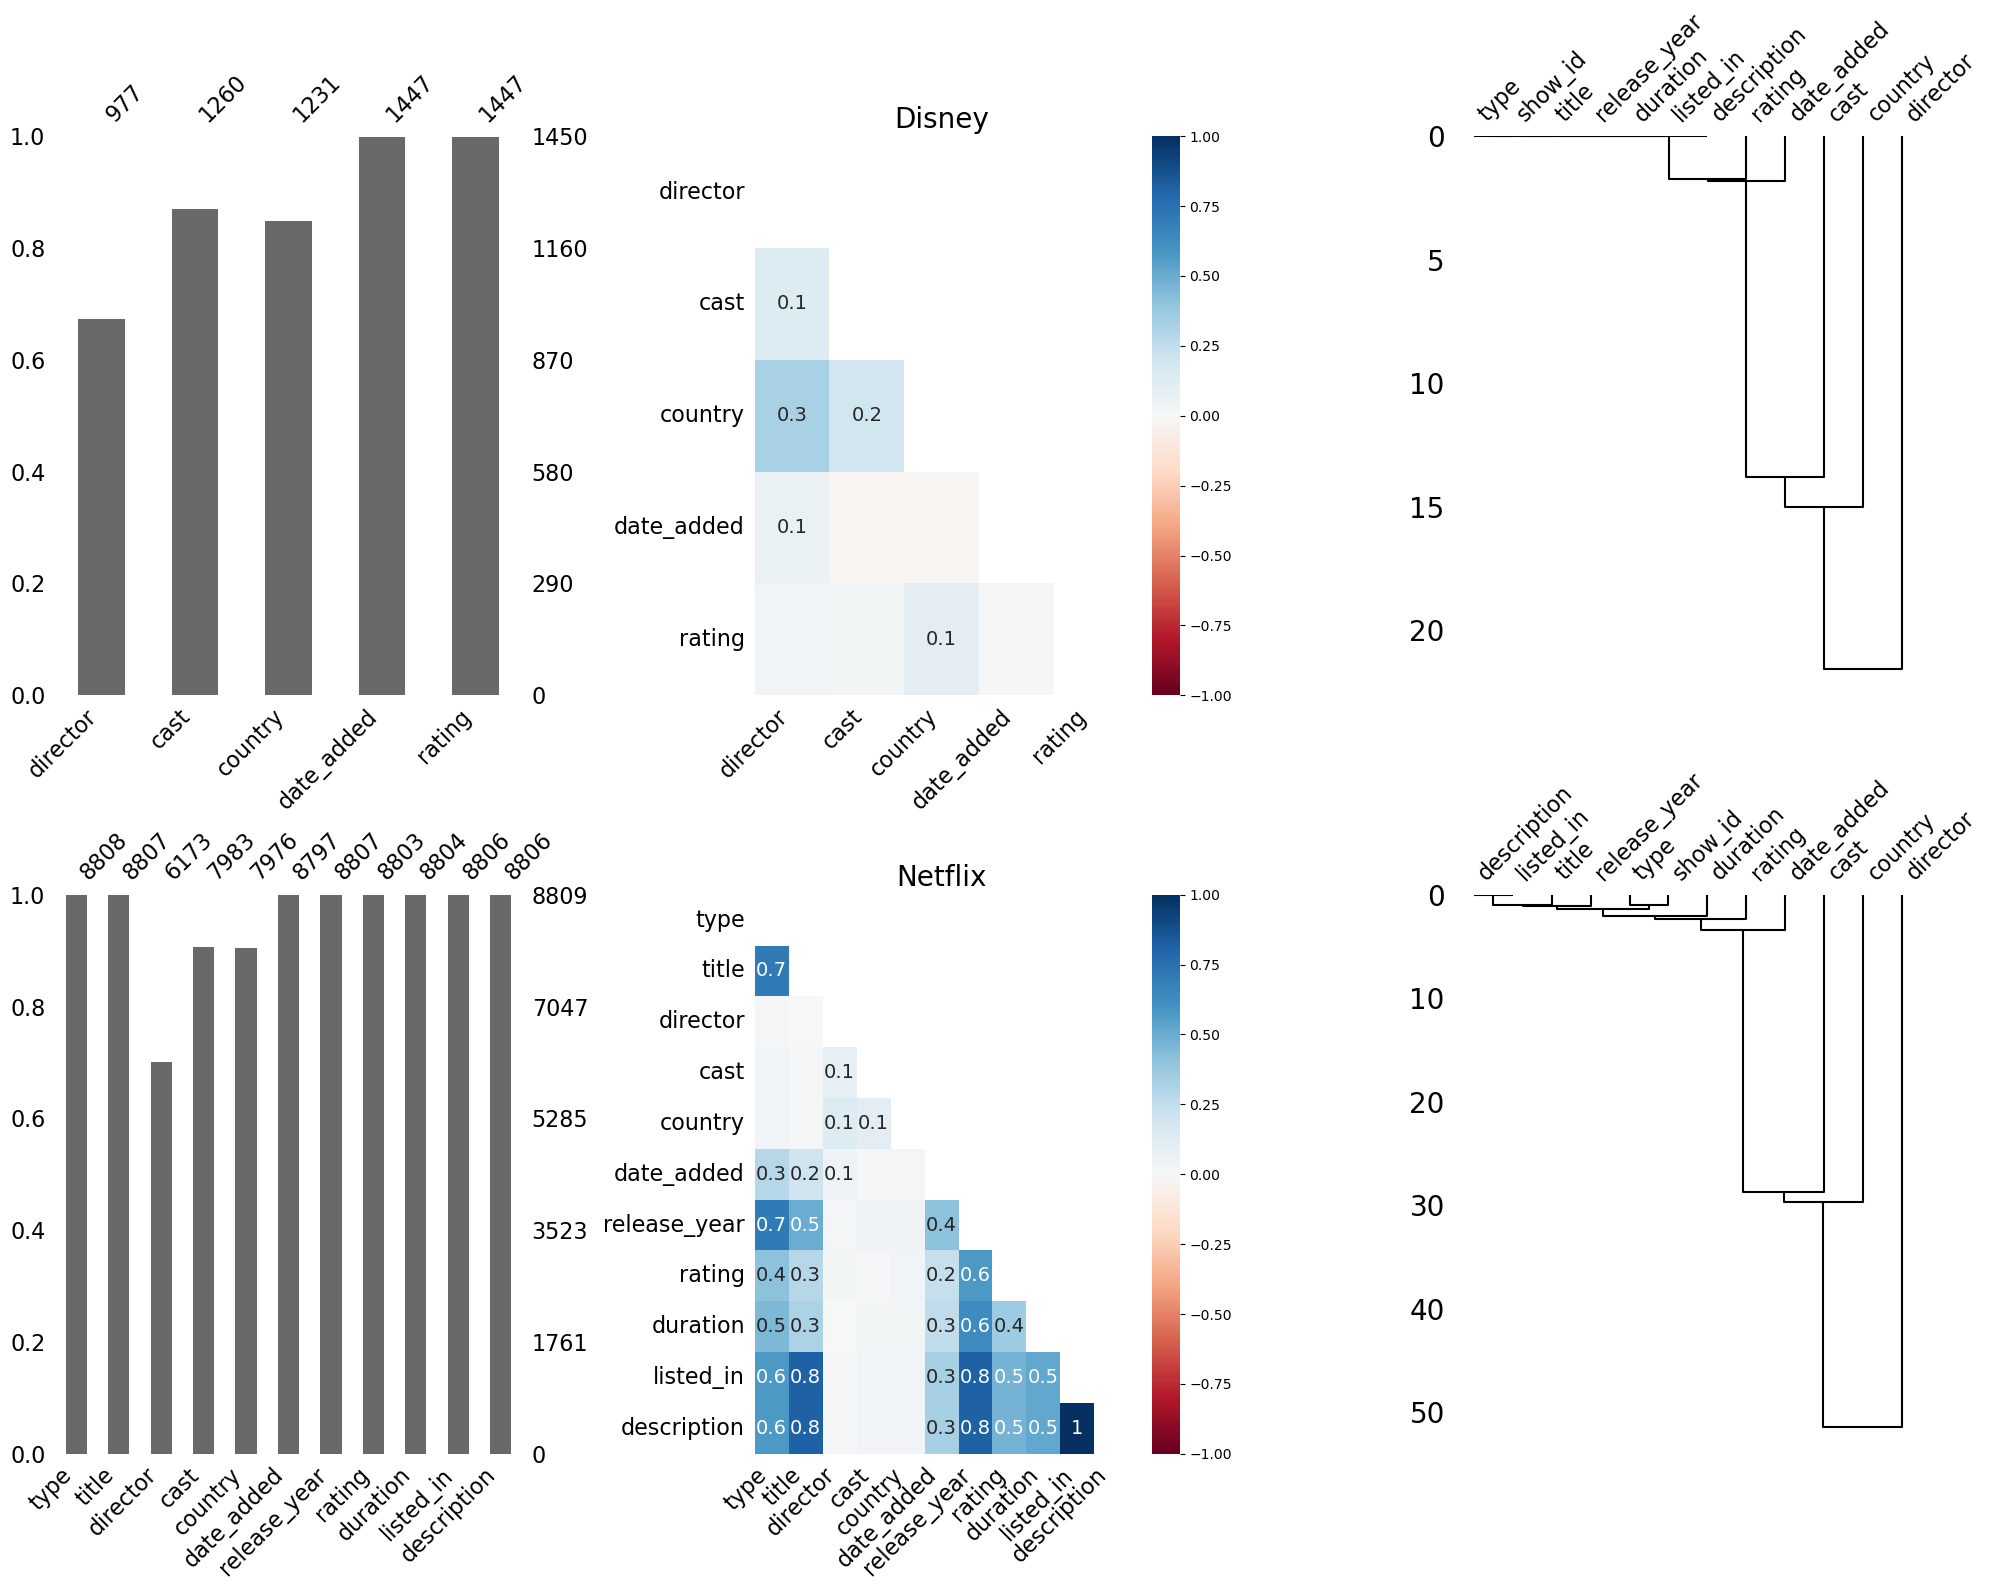

In [42]:
def plot_missing(df, df2):
    fig, ax = plt.subplots(2,3,figsize=(20, 16))
    msno.bar(df.loc[:, df.isna().any()], ax=ax[0,0])
    msno.heatmap(df, ax=ax[0,1])
    ax[0,1].set_title('Disney', fontsize=20)
    msno.dendrogram(df, ax=ax[0,2])

    msno.bar(df2.loc[:, df2.isna().any()], ax=ax[1,0])
    msno.heatmap(df2, ax=ax[1,1])
    ax[1,1].set_title('Netflix', fontsize=20)
    msno.dendrogram(df2, ax=ax[1,2])

    plt.tight_layout()
    plt.show()

plot_missing(disney, netflix)

In [43]:
mask = netflix['type'] == 'TV Show'
value_tv_na_director = netflix.loc[mask,'director'].isna().sum()/netflix.loc[mask,'director'].shape[0]*100

print('Percentage of missing values in director column for TV Shows in Netflix: ', value_tv_na_director.round(2), '%')

mask = netflix['type'] == 'Movie'
value_movie_na_director = netflix.loc[mask,'director'].isna().sum()/netflix.loc[mask,'director'].shape[0]*100
print('Percentage of missing values in director column for Movie in Netflix: ', value_movie_na_director.round(2), '%')

mask = disney['type'] == 'TV Show'
value_tv_na_director = disney.loc[mask,'director'].isna().sum()/disney.loc[mask,'director'].shape[0]*100

print('Percentage of missing values in director column for TV Shows in Disney: ', value_tv_na_director.round(2), '%')

mask = netflix['type'] == 'Movie'
value_movie_na_director = disney.loc[mask,'director'].isna().sum()/disney.loc[mask,'director'].shape[0]*100
print('Percentage of missing values in director column for Movie in Disney: ', value_movie_na_director.round(2), '%')

Percentage of missing values in director column for TV Shows in Netflix:  91.41 %
Percentage of missing values in director column for Movie in Netflix:  3.08 %
Percentage of missing values in director column for TV Shows in Disney:  100.0 %
Percentage of missing values in director column for Movie in Disney:  32.14 %


#### Impressions regarding missing values:
The rate of missing data seems similar for both variables, but in Netflix there is a strong correlation between the missing data, as seen in both the heatmap and the dendrogram.

The 30% of missing data for the director is notable, but this makes sense since it is common for a series, especially if it has many seasons, to have multiple directors. It makes sense that they may not be listed or may not be relevant to the person who performed the data entry for the dataset.

## 2) EDA: 

### - c) GRAPHICS COMPARISON FOR EACH FEATURE

### * TYPE OF SHOW

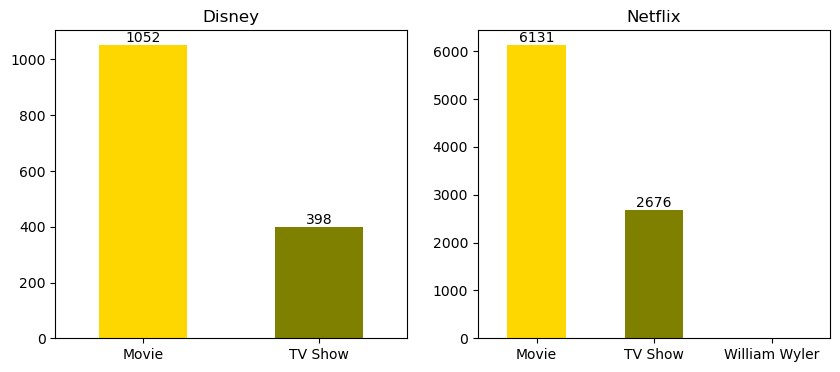

In [44]:
def plot1(df1,df2):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    mask1 = df1['type'] == 'TV Show'
    mask2 = df2['type'] == 'TV Show'

    df1['type'].value_counts().plot(kind='bar', title='Disney',ax=ax[0], color=['gold', 'olive'])
    ax[0].tick_params(axis='x', rotation=0)
    max1movie = max(df1['type'].value_counts())
    max1tv = max(df1['type'][mask1].value_counts())
    ax[0].text(0, max1movie, str(max1movie), ha='center', va='bottom')
    ax[0].text(1, max1tv, str(max1tv), ha='center', va='bottom')


    

    df2['type'].value_counts().plot(kind='bar', title='Netflix',ax=ax[1],color=['gold', 'olive'])
    ax[1].tick_params(axis='x', rotation=0)
    max2movie = max(df2['type'].value_counts())
    max2tv = max(df2['type'][mask2].value_counts())
    ax[1].text(0, max2movie, str(max2movie), ha='center', va='bottom')
    ax[1].text(1, max2tv, str(max2tv), ha='center', va='bottom')

    plt.show()

plot1(disney, netflix)

It can already be seen that there are corrupt data because an actor's name has "sneaked" into the "type" column.

### * DIRECTOR, CAST, COUNTRY

In [45]:
def countOccurrence(a):
    k = {}
    for j in a:
        if j in k:
            k[j] +=1
        else:
            k[j] =1
    return k

def find_matches(list_of_dicts):
    list_of_keys = []
    for i in range(len(list_of_dicts)):
        list_of_keys.append(list(list_of_dicts[i].keys()))
    
    set1 = set(list_of_keys[0])
    set2 = set(list_of_keys[1])

    return set1.intersection(set2)

def show_most_wanted(df ,list_of_columns, split_with = ','):
    empty_list = []

    for column in list_of_columns:
        temp_list = list(chain(*df[column].fillna('', axis=0).map(lambda x: x.split(split_with)).tolist()))
        temp_list = [x for x in temp_list if len(x)>0]
        temp_list = [x.strip() for x in temp_list]
        dict_temp = countOccurrence(temp_list)
        empty_list.append(dict_temp)

    
    list_of_columns = list(chain(*list(zip([x.capitalize() for x in list_of_columns],[x.capitalize() + '_Count' for x in list_of_columns]))))

    list_of_df = []
    for i in range(len(empty_list)):
        df_temp = pd.DataFrame(empty_list[i], index = [i]).T.sort_values(by = i, ascending = False).head(20)
        df_temp = df_temp.reset_index()
        list_of_df.append(df_temp)
    
    df_final = pd.concat(list_of_df, axis=1)

    df_final.columns = list_of_columns

    lista_matches = find_matches(empty_list[0:2])
    
    return df_final, lista_matches

#### Top 10 directors, actors, countries, and categories for Netflix and Disney

In [46]:
list_of_interest = ['director', 'cast', 'country', 'listed_in']
top_categoricals_disney, lista_matches_disney = show_most_wanted(disney, list_of_interest)
print('*'*20,'Top 10 Categoricals Disney', '*'*20)
top_categoricals_disney.head(10)

******************** Top 10 Categoricals Disney ********************


,Director,Director_Count,Cast,Cast_Count,Country,Country_Count,Listed_in,Listed_in_Count
0,Jack Hannah,17,Jim Cummings,33,United States,1184,Family,632
1,John Lasseter,16,Walt Disney,20,United Kingdom,101,Animation,542
2,Wilfred Jackson,16,Larry the Cable Guy,19,Canada,77,Comedy,526
3,Paul Hoen,16,Bill Farmer,18,Australia,23,Action-Adventure,452
4,Robert Stevenson,13,Keith Ferguson,16,France,22,Animals & Nature,208
5,Clyde Geronimi,13,Tress MacNeille,16,South Korea,13,Coming of Age,205
6,Charles Nichols,12,Corey Burton,16,China,10,Fantasy,192
7,Jack Kinney,12,Pinto Colvig,15,Japan,10,Documentary,174
8,James Algar,11,Bob Peterson,15,Germany,9,Kids,141
9,Vincent McEveety,10,Jeff Bennett,15,Ireland,8,Drama,134


In [47]:
print('Total matches between director and cast in Disney: ', len(list(lista_matches_disney)))
print('\nExamples of matches between director and cast in Disney: \n', ', '.join(list(lista_matches_disney)[0:20]))

Total matches between director and cast in Disney:  52

Examples of matches between director and cast in Disney: 
 Dave Hoffman, Louis Gonzales, Jon Favreau, Kelsey Mann, Zhong Yu, Tim Conrad, Mark Monroe, Joe Camp, Thomas Kail, Angus MacLane, Mark Taylor, Ralph Wright, John Kahrs, Dan Povenmire, Steve Purcell, Don Hahn, Taika Waititi, Brad Bird, Christopher Sanders, Ron Clements


In [48]:
top_categoricals_netflix, lista_matches_netflix= show_most_wanted(netflix, list_of_interest)
print('*'*20,'Top 10 Categoricals Netflix', '*'*20)
top_categoricals_netflix.head(10)

******************** Top 10 Categoricals Netflix ********************


,Director,Director_Count,Cast,Cast_Count,Country,Country_Count,Listed_in,Listed_in_Count
0,Rajiv Chilaka,22,Anupam Kher,43,United States,3689,International Movies,2752
1,Jan Suter,21,Shah Rukh Khan,35,India,1046,Dramas,2427
2,Raúl Campos,19,Julie Tejwani,33,United Kingdom,806,Comedies,1674
3,Suhas Kadav,16,Naseeruddin Shah,32,Canada,445,International TV Shows,1351
4,Marcus Raboy,16,Takahiro Sakurai,32,France,393,Documentaries,868
5,Jay Karas,15,Rupa Bhimani,31,Japan,318,Action & Adventure,859
6,Cathy Garcia-Molina,13,Akshay Kumar,30,Spain,232,TV Dramas,763
7,Youssef Chahine,12,Om Puri,30,South Korea,231,Independent Movies,756
8,Martin Scorsese,12,Yuki Kaji,29,Germany,226,Children & Family Movies,641
9,Jay Chapman,12,Paresh Rawal,28,Mexico,169,Romantic Movies,616


In [49]:
print('Total matches between director and cast in Netflix: ', len(list(lista_matches_netflix)))
print('\nExamples of matches between director and cast in Netflix: \n', ', '.join(list(lista_matches_netflix)[0:20]))

Total matches between director and cast in Netflix:  484

Examples of matches between director and cast in Netflix: 
 Anand Tiwari, Guillermo del Toro, Kevin Phillips, Nate Adams, Bo Burnham, Fouad El-Mohandes, Falz, Michael Blieden, Judah Friedlander, Linas Phillips, Jenna Laurenzo, Grant Heslov, Lucien Jean-Baptiste, Rana Eid, Martin Lawrence, Peter Lord, Sylvester Stallone, Clovis Cornillac, Sunil Sukthankar, Jennifer Morrison


It is common (or normal) for a director to sometimes act in a movie. 

In the case of Netflix, this represents a 5% match. 

A unique list of "people" could be created, followed by lists with their roles.

### * DATE ADDED

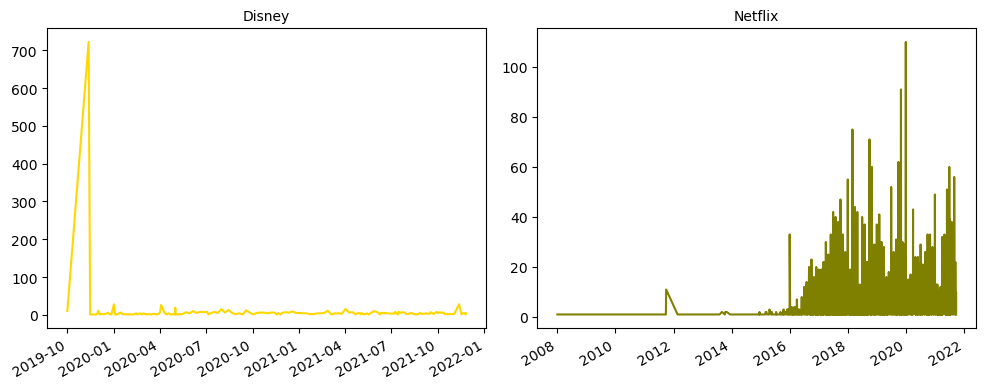

In [50]:
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
disney['date_added'].value_counts().plot(ax=ax[0], color=['gold'])
ax[0].set_title('Disney', fontsize=10)
netflix['date_added'].value_counts().plot(ax=ax[1], color=['olive'])
ax[1].set_title('Netflix', fontsize=10)
plt.tight_layout()
plt.show()

### DATE ADDED BY YEAR

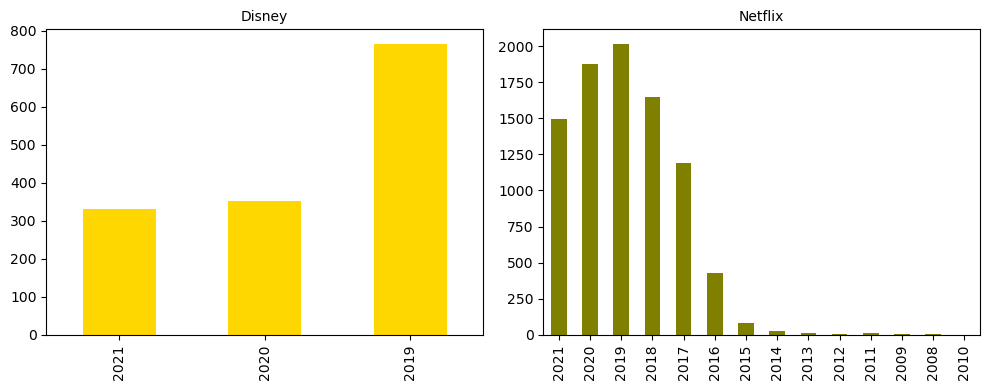

In [51]:
temp_netflix = netflix.set_index('date_added')
temp_netflix.index = pd.to_datetime(temp_netflix.index, errors='coerce')
temp_disney = disney.set_index('date_added')
temp_disney.index = pd.to_datetime(temp_disney.index, errors='coerce')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

temp_disney.index.to_period('Y').value_counts(sort= False).plot(kind='bar', color=['gold'], ax=ax[0])
ax[0].set_title('Disney', fontsize=10)

temp_netflix.index.to_period('Y').value_counts(sort = False).plot(kind='bar', color=['olive'], ax=ax[1])
ax[1].set_title('Netflix', fontsize=10)
plt.tight_layout()
plt.show()

### * RELEASE YEAR

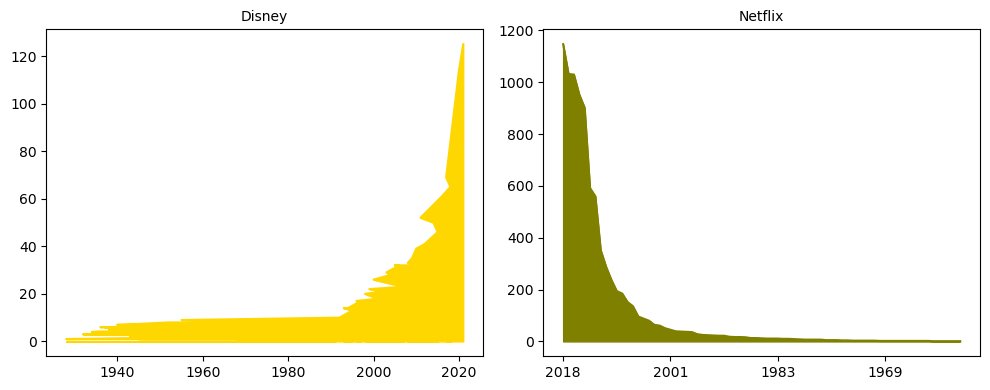

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
disney['release_year'].value_counts().plot(kind = 'area',ax=ax[0], color = ['gold'])
ax[0].set_title('Disney', fontsize=10)
netflix['release_year'].value_counts().plot(kind = 'area',ax=ax[1], color = ['olive'])
ax[1].set_title('Netflix', fontsize=10)
plt.tight_layout()
plt.show()

### * RATING

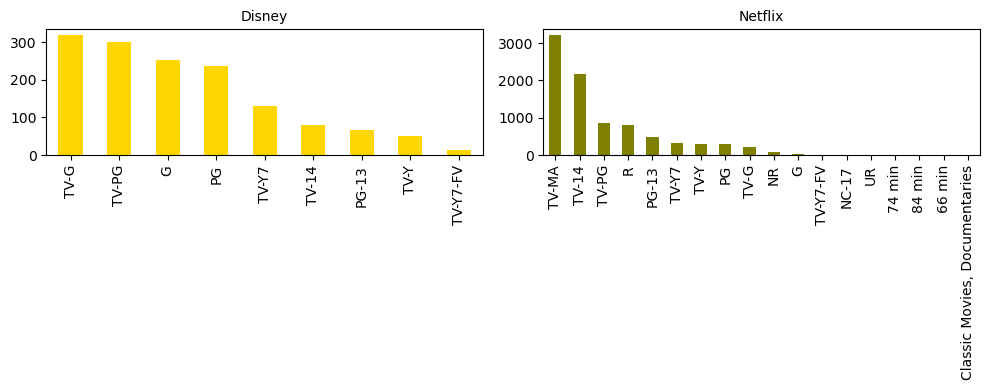

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
disney['rating'].value_counts().plot(kind = 'bar',ax=ax[0], color = ['gold'])
ax[0].set_title('Disney', fontsize=10)
netflix['rating'].value_counts().plot(kind = 'bar',ax=ax[1], color = ['olive'])
ax[1].set_title('Netflix', fontsize=10)
plt.tight_layout()
plt.show()

Again we can see corrupted data, probably there is some wrong line on the CSV from Netflix. 

### * DURATION
#### DURATION by seasons on TV shows

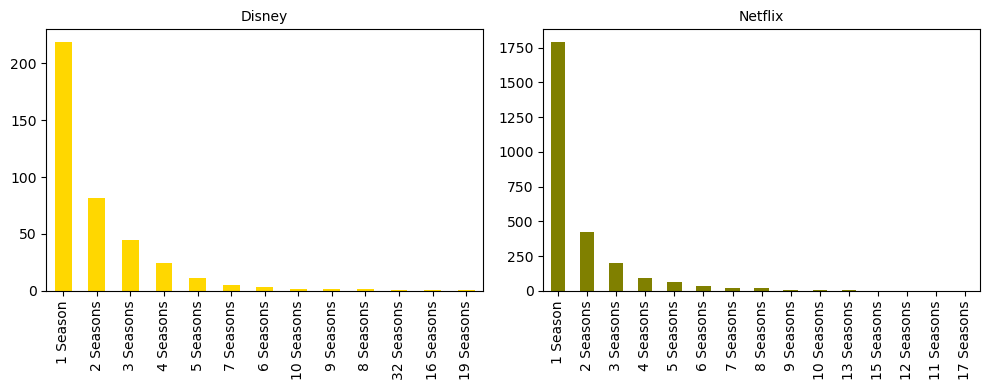

In [54]:
mask1 = disney['type'] == 'TV Show'
mask2 = netflix['type'] == 'TV Show'
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
disney[mask1]['duration'].value_counts().plot(kind = 'bar',ax=ax[0], color = ['gold'])
ax[0].set_title('Disney', fontsize=10)
netflix[mask2]['duration'].value_counts().plot(kind = 'bar',ax=ax[1], color = ['olive'])
ax[1].set_title('Netflix', fontsize=10)
plt.tight_layout()
plt.show()

#### DURATION FOR MOVIES IN MINUTES

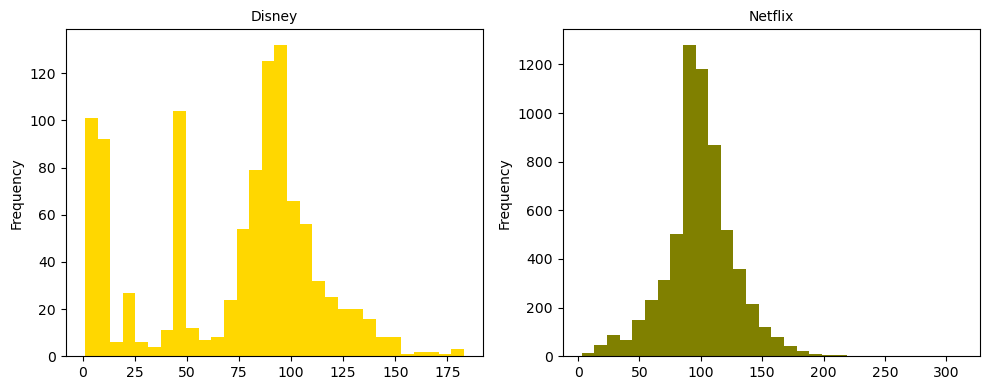

,Disney,Netflix
count,1052.000000,6127.000000
mean,71.910646,99.586910
std,40.595585,28.282659
min,1.000000,3.000000
25%,44.000000,87.000000
50%,85.000000,98.000000
75%,98.000000,114.000000
max,183.000000,312.000000


In [55]:
mask1 = disney['type'] == 'Movie'
mask2 = netflix['type'] == 'Movie'
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
disney.loc[mask1, 'duration'].str.replace('min', '').astype(int).plot(kind = 'hist',bins = 30, ax=ax[0], color = ['gold'])
ax[0].set_title('Disney', fontsize=10)
netflix.loc[mask2, 'duration'].str.replace('min', '').dropna(axis=0).astype(int).plot(kind = 'hist',bins = 30, ax=ax[1], color = ['olive'])
ax[1].set_title('Netflix', fontsize=10)
plt.tight_layout()
plt.show()

stats_duration_disney = pd.DataFrame(disney.loc[mask1, 'duration'].str.replace('min', '').astype(int).describe()).rename(columns={'duration':'Disney'})
stats_duration_netflix = pd.DataFrame(netflix.loc[mask2, 'duration'].str.replace('min', '').dropna(axis=0).astype(int).describe()).rename(columns={'duration':'Netflix'})

stats_duration = pd.concat([stats_duration_disney, stats_duration_netflix], axis=1)
stats_duration

## 2) EDA: 

### - d) OUTLIERS

It is noteworthy the large number of short films that Disney has.

And that significant outlier on Netflix with a duration > 300 minutes, which is actually the interactive Black Mirror movie.

In [56]:
mask = netflix['duration'] == '312 min'
netflix[mask]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
id,,,,,,,,,,,,
4253,s4254,Movie,Black Mirror: Bandersnatch,NaN,"Fionn Whitehead, Will Poulter, Craig Parkinson...",United States,2018-12-28,2018,TV-MA,312 min,"Dramas, International Movies, Sci-Fi & Fantasy","In 1984, a young programmer begins to question..."


#### Disney shorts movies < 20 minutes

In [57]:
mask1 = disney['type'] == 'Movie'
mask2 = disney.loc[mask1, 'duration'].str.replace('min', '').astype(int) < 20
print('Number of short films from Disney: ', disney[mask1].loc[mask2].shape[0])
disney[mask1].loc[mask2].head(5)

Number of short films from Disney:  199


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
id,,,,,,,,,,,,
11,s12,Movie,Puppy for Hanukkah,NaN,NaN,NaN,2021-11-19,2020,TV-G,4 min,"Comedy, Family, Music","Check out Daveed Digg's official music video ""..."
14,s15,Movie,America the Beautiful,NaN,Michael B. Jordan,NaN,2021-11-12,2021,TV-PG,2 min,Animals & Nature,"Epic, grand portrait of the land across four r..."
15,s16,Movie,Baymax!,NaN,NaN,NaN,2021-11-12,2021,TV-G,1 min,Animation,“Baymax!” premieres on Disney+ summer 2022.
16,s17,Movie,Ciao Alberto,McKenna Harris,"Jack Dylan Grazer, Marco Barricelli",NaN,2021-11-12,2021,TV-PG,8 min,"Animation, Comedy, Family",Fun-loving sea monster Alberto whole-heartedly...
20,s21,Movie,Feast,Patrick Osborne,"Stephen Apostolina, Kirk Baily, Ben Bledsoe, D...",United States,2021-11-12,2014,G,8 min,"Animation, Comedy, Drama",One man's love life seen through the eyes of h...


## 2) EDA: 

### - e) TEXT DATA

#### TITLE AND DESCRIPTION
Just to check that there isn't an "excessive" amount of incorrect words and to see which terms are most frequently used for titles and descriptions on each platform we are gonna print two wordclouds

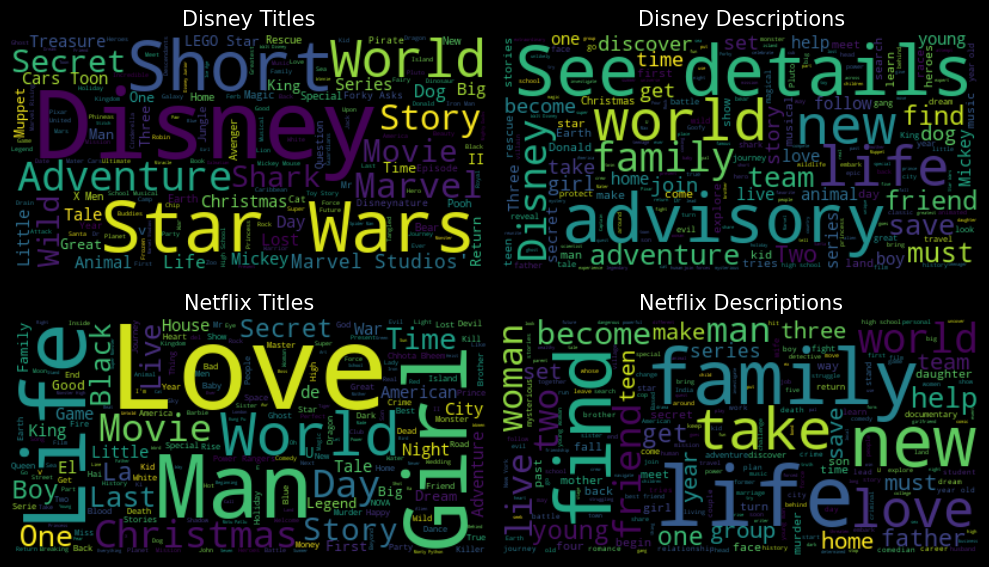

In [58]:
plain_text_title_d = ' '.join(disney['title'].fillna('', axis=0).tolist())
cloud_disney_t = WordCloud(stopwords = stopwords).generate(plain_text_title_d)

plain_text_description_d = ' '.join(disney['description'].fillna('', axis=0).tolist())
cloud_disney_d = WordCloud(stopwords = stopwords).generate(plain_text_description_d)

plain_text_title_n = ' '.join(netflix['title'].fillna('', axis=0).tolist())
cloud_netflix_t = WordCloud(stopwords = stopwords).generate(plain_text_title_n)

plain_text_description_n = ' '.join(netflix['description'].fillna('', axis=0).tolist())
cloud_netflix_d = WordCloud(stopwords = stopwords).generate(plain_text_description_n)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0,0].imshow(cloud_disney_t, interpolation='bilinear')
ax[0,0].set_title('Disney Titles', fontsize=15, color='white')
ax[0,0].axis('off')

ax[0,1].imshow(cloud_disney_d, interpolation='bilinear')
ax[0,1].set_title('Disney Descriptions', fontsize=15, color='white')
ax[0,1].axis('off')

ax[1,0].imshow(cloud_netflix_t, interpolation='bilinear')
ax[1,0].set_title('Netflix Titles', fontsize=15, color='white')
ax[1,0].axis('off')

ax[1,1].imshow(cloud_netflix_d, interpolation='bilinear')
ax[1,1].set_title('Netflix Descriptions', fontsize=15, color='white')
ax[1,1].axis('off')

fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()

## 2) EDA: 

### - f) DUPLICATED DATA 
Are there duplicate data between both platforms? That is, are the shows repeated?

In [59]:
disney['origin'] = 'Disney'

netflix['origin'] = 'Netflix'

total_shows = pd.concat([disney, netflix], axis=0)

mask_duplicates = total_shows['title'].duplicated()

print('Total of duplicated movies that match "Title" in both datasets: ', total_shows[mask_duplicates].shape[0])

Total of duplicated movies that match "Title" in both datasets:  44


In [60]:
print('Total of duplicated with all rows matching same: ', total_shows.duplicated().sum())

Total of duplicated with all rows matching same:  0


Shows with the same title are repeated, but they do not have the same data in the rest of the features.
In this case, it is possible that the shows with the same title are different versions, adaptations, or have some variations in their production (such as different directors, cast members, or release years). 

#### DUPLICATED TITLES OBSERVATIONS
There are series/movies that are the same (matching cast and directors), but the duration or rating is different.
There are series that have more or fewer seasons available depending on the platform.
There are titles that are similar but the movie is from another country and has a 10-year difference (see the last one titled Genius).

In [61]:
list_duplicates = total_shows.loc[mask_duplicates, 'title'].tolist()

duplicated_df = pd.DataFrame(columns=netflix.columns.tolist())
for movie in list_duplicates:
    mask = disney['title'] == movie
    mask2 = netflix['title'] == movie
    duplicated_df = pd.concat([duplicated_df, netflix[mask2]], axis=0)
    duplicated_df = pd.concat([duplicated_df, disney[mask]], axis=0)

duplicated_df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,origin
1014,s1015,TV Show,PJ Masks,NaN,"Jacob Ewaniuk, Kyle Breitkopf, Addison Holley","France, United Kingdom",2021-04-19,2019,TV-Y,3 Seasons,Kids' TV,Three 6-year-old kids who live normal lives du...,Netflix
58,s59,TV Show,PJ Masks,NaN,"Kyle Breitkopf, Jacob Ursomarzo, Addison Holley","France, United Kingdom",2021-10-20,2015,TV-Y7,5 Seasons,"Action-Adventure, Animation, Kids",Look out Night Time Baddies the PJ Masks are c...,Disney
1570,s1571,TV Show,Once Upon a Time,NaN,"Ruby, Mohamed Farraag, Ahmed Dawood, Sawsan Ba...",Egypt,2020-12-09,2019,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...",Fighting to save his ancestors' mansion from d...,Netflix
412,s413,TV Show,Once Upon a Time,NaN,"Ginnifer Goodwin, Jennifer Morrison, Robert Ca...",United States,2020-09-18,2011,TV-PG,7 Seasons,"Action-Adventure, Fantasy, Soap Opera / Melodrama",Fairy tale characters inhabit a land of good a...,Disney
2225,s2226,TV Show,Gigantosaurus,NaN,NaN,France,2020-07-18,2019,TV-Y,1 Season,Kids' TV,Four prehistoric friends go on an array of adv...,Netflix
126,s127,TV Show,Gigantosaurus,NaN,"Dylan Schombing, Áine Sunderland, Nahanni Mitc...",France,2021-08-25,2018,TV-Y,2 Seasons,"Action-Adventure, Animation, Kids",Four dinos explore the mystery of the Gigantos...,Disney
2559,s2560,Movie,Becoming,Nadia Hallgren,Michelle Obama,United States,2020-05-06,2020,PG,89 min,Documentaries,Join former first lady Michelle Obama in an in...,Netflix
405,s406,TV Show,Becoming,NaN,NaN,United States,2020-09-18,2020,TV-PG,1 Season,"Anthology, Docuseries, Family",Becoming chronicles the origin stories of worl...,Disney
4094,s4095,Movie,Genius,Suseenthiran,"Roshan, Priyaa Lal, Aadukalam Naren, Singam Pu...",India,2019-02-17,2018,TV-14,96 min,"Dramas, Independent Movies, International Movies",Extreme pressure from his father to excel at s...,Netflix
909,s910,Movie,Genius,Rod Daniel,"Trevor Morgan, Emmy Rossum, Yannick Bisson, Pe...",United States,2019-11-12,1999,TV-G,86 min,"Comedy, Coming of Age",A teen genius juggles the roles of college stu...,Disney


In [62]:
mask = disney['title'] == 'A Wrinkle in Time'
mask2 = netflix['title'] == 'A Wrinkle in Time'

pd.concat([disney[mask], netflix[mask2]], axis=0)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,origin
id,,,,,,,,,,,,,
599,s600,Movie,A Wrinkle in Time,Ava DuVernay,"Oprah Winfrey, Reese Witherspoon, Mindy Kaling...",United States,2020-03-25,2018,PG,112 min,"Action-Adventure, Coming of Age, Family",Meg travels through time and space to find her...,Disney
6065,s6066,Movie,A Wrinkle in Time,Ava DuVernay,"Storm Reid, Oprah Winfrey, Reese Witherspoon, ...",United States,2018-09-25,2018,PG,110 min,Children & Family Movies,"Years after their father disappears, Meg and h...",Netflix


## 3) TRANSFORMATION: 

### - a) DATA VALIDATION 

Here it is clear that row 8420 is corrupt and has an accidental line break. Therefore, there are two "corrupt" rows.

In [63]:
mask = netflix['type'].str.contains('William', na = False)
netflix.iloc[mask.tolist().index(True)-2:mask.tolist().index(True)+2]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,origin
id,,,,,,,,,,,,,
8419,s8419,Movie,The Mayor,Park In-je,"Min-sik Choi, Do-won Kwak, Eun-kyung Shim, So-...",South Korea,2017-09-30,2017,TV-MA,130 min,"Dramas, International Movies","With the presidency in mind, the incumbent may...",Netflix
8420,s8420,Movie,The Memphis Belle: A Story of a,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,Netflix
8421,"Flying Fortress""",William Wyler,NaN,United States,"March 31, 2017",1944,NaT,40 min,"Classic Movies, Documentaries",This documentary centers on the crew of the B-...,NaN,NaN,Netflix
8422,s8421,Movie,The Men Who Stare at Goats,Grant Heslov,"George Clooney, Ewan McGregor, Jeff Bridges, K...","United States, United Kingdom",2019-06-04,2009,R,94 min,Comedies,A journalist latches onto an unbelievable stor...,Netflix


### SOLUTION: converters when importing the CSV and saving a record of corrupt data

##### Objectives of this approach:
- Save the index of the row and the corrupt values for later analysis.
- Remove rows that have > 5 columns with NA (these can be corrupt or not).

##### Possible difficulties with this approach:
This would be inconvenient for very large datasets; with Pandas, it would only be possible to do this in chunks (and in the same loop, upload the information to the database... and then check what was uploaded and continue performing ETL). Transforming all the data before uploading it would require using distributed solutions like Spark, both locally or in the cloud (for example, Databricks).

Another possibility would be to upload only the rows not listed in the set_of_wrong_indexs attribute, and then upload the remaining rows after analyzing them or upload them to another table.

#### PANDAS CONVERTERS

In [64]:
# This class is responsible for cleaning the data from the CSV files so they can be used in the project
# All methods of the class receive a dataframe value as a parameter
# They check the integrity of the data
# If the check passes, they return the original value
# If the check fails, they return a null value and store the value and row index in a dictionary


class data_cleaner:
    ## Class constructor
    ## Initializes class attributes
    ## Creates an empty dictionary to store the indices and values of rows containing errors
    def __init__(self):
        self.set_of_wrong_indexs = set()
        self.counter_index_show_id = -1
        self.counter_index_type = -1
        self.counter_index_title = -1
        self.counter_index_director = -1
        self.counter_index_cast = -1
        self.counter_index_country = -1
        self.counter_index_date_added = -1
        self.counter_index_release_year = -1
        self.counter_index_rating = -1
        self.counter_index_duration = -1
        self.counter_index_listed_in = -1
        self.counter_index_description = -1
        self.list_or_errors = {
            'show_id': [],
            'type': [],
            'title': [],
            'director': [],
            'cast': [],
            'country': [],
            'date_added': [],
            'release_year': [],
            'rating': [],
            'duration': [],
            'listed_in': [],
            'description': []
        }

    ## This method is responsible for cleaning the show or movie ID 
    def correct_show_id(self, x):
        if re.match('s', x):
            self.counter_index_show_id += 1
            return x
        else:
            self.counter_index_show_id += 1
            self.set_of_wrong_indexs.add(self.counter_index_show_id)
            print(f'Value from index {self.counter_index_show_id} is wrong in column "show_id": {x}. Replaced with NaN')
            self.list_or_errors['show_id'].append([self.counter_index_show_id, x])
            return np.nan
    ## This method is responsible for cleaning the show type
    def correct_type(self, x):
        if x in ['Movie', 'TV Show']:
            self.counter_index_type += 1
            return x
        else:
            self.counter_index_type += 1
            self.set_of_wrong_indexs.add(self.counter_index_type)
            print(f'Value from index {self.counter_index_type} is wrong in column "type": {x}. Replaced with NaN')
            self.list_or_errors['type'].append([self.counter_index_type, x])
            return np.nan

    ## This method is responsible for cleaning the show or movie title
    def correct_title(self, x):
        if not re.search(r'\d{5,}',x):
            self.counter_index_title += 1
            return x
        else:
            self.counter_index_title += 1
            self.set_of_wrong_indexs.add(self.counter_index_title)
            print(f'Value from index {self.counter_index_title} is wrong in column "title": {x}. Replaced with NaN')
            self.list_or_errors['title'].append([self.counter_index_title, x])
            return np.nan

    ## This method is responsible for cleaning director name
    def correct_director(self, x):
        if not re.search(r'\d',x):
            self.counter_index_director += 1
            return x
        else:
            self.counter_index_director += 1
            self.set_of_wrong_indexs.add(self.counter_index_director)
            print(f'Value from index {self.counter_index_director} is wrong in column "director": {x}. Replaced with NaN')
            self.list_or_errors['director'].append([self.counter_index_director, x])
            return np.nan

    ## This method is responsible for cleaning the cast of the show or movie
    def correct_cast(self, x):
        if x not in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] and re.search(r'\D',x):
            self.counter_index_cast+= 1
            return x
        else:
            self.counter_index_cast += 1
            self.set_of_wrong_indexs.add(self.counter_index_cast)
            print(f'Value from index {self.counter_index_cast} is wrong in column "cast": {x}. Replaced with NaN')
            self.list_or_errors['cast'].append([self.counter_index_cast, x])
            return np.nan

    ## This method is responsible for cleaning the country where the show or movie was produced
    def correct_country(self, x):
        if not re.search(r'\d',x):
            self.counter_index_country += 1
            return x
        else:
            self.counter_index_country += 1
            self.set_of_wrong_indexs.add(self.counter_index_country)
            print(f'Value from index {self.counter_index_country} is wrong in column "country": {x}. Replaced with NaN')
            self.list_or_errors['country'].append([self.counter_index_country, x])
            return np.nan

    ## This method is responsible for cleaning the date when the show or movie was added to the platform
    def correct_date_added(self, x):
        try:
            return pd.to_datetime(x)
        except:
            self.set_of_wrong_indexs.add(self.counter_index_date_added+1)
            print(f'Value from index {self.counter_index_date_added+1} is wrong in column "date_added": {x}. Replaced with NaT')
            self.list_or_errors['date_added'].append([self.counter_index_date_added+1, x])
            return pd.to_datetime(x, errors='coerce')
        finally:
            self.counter_index_date_added += 1

    ## This method is responsible for cleaning the year when the show or movie was released
    def correct_release_year(self, x):
        try: 
            return int(x)
        except:
            print(f'Value from index {self.counter_index_release_year+1} is wrong in column "years": {x}. Replaced with NaN')
            self.set_of_wrong_indexs.add(self.counter_index_release_year+1)
            self.list_or_errors['release_year'].append([self.counter_index_release_year+1, x])
            return np.nan
        finally:
            self.counter_index_release_year+1

    ## This method is responsible for cleaning the rating of the show or movie
    def correct_rating(self, x):
        if x in ['TV-MA', 'TV-14', 'TV-PG', 'R', 'PG-13', 'PG', 'NR', 'TV-Y7', 'TV-Y', 'TV-G', 'G', 'NC-17', 'UR','TV-Y7-FV']:
            self.counter_index_rating += 1
            return x
        else:
            self.counter_index_rating += 1
            self.set_of_wrong_indexs.add(self.counter_index_rating)
            print(f'Value from index {self.counter_index_rating} is wrong in column "rating": {x}. Replaced with NaN')
            self.list_or_errors['rating'].append([self.counter_index_rating, x])
            return np.nan

    ## This method is responsible for cleaning the duration of the show or movie
    def correct_duration(self, x):
        if re.search(r'(?:min)|(?:eason)', x):
            self.counter_index_duration += 1
            return int(re.match(r'\d+', x).group())
        else:
            self.counter_index_duration += 1
            self.set_of_wrong_indexs.add(self.counter_index_duration)
            print(f'Value from index {self.counter_index_duration} is wrong in column "duration": {x}. Replaced with NaN')
            self.list_or_errors['duration'].append([self.counter_index_duration, x])
            return np.nan

    ## This method is responsible for cleaning the genre of the show or movie
    def correct_listed_in(self, x):
        if not re.search(r'\d',x):
            self.counter_index_listed_in += 1
            return x
        else:
            self.counter_index_listed_in += 1
            self.set_of_wrong_indexs.add(self.counter_index_listed_in)
            print(f'Value from index {self.counter_index_listed_in} is wrong in column "listed_in": {x}. Replaced with NaN')
            self.list_or_errors['listed_in'].append([self.counter_index_listed_in, x])
            return np.nan

    ## This method is responsible for cleaning the description of the show or movie
    def correct_description(self, x):
        if not re.search(r"^\d+$",x):
            self.counter_index_description += 1
            return x
        else:
            self.counter_index_description += 1
            self.set_of_wrong_indexs.add(self.counter_index_description)
            print(f'Value from index {self.counter_index_description} is wrong in column "description": {x}. Replaced with NaN')
            self.list_or_errors['description'].append([self.counter_index_description, x])
            return np.nan

    ## This method get the indexs of the rows with wrong data
    def get_wrong_data_index(self):
        return self.set_of_wrong_indexs, self.list_or_errors

    ## This methods print the indexs of the rows with wrong data
    def get_wrong_data_simplier(self):
        check= 0
        for i in self.list_or_errors.keys():
            checker = [str(x) + ' ' + y for x,y in self.list_or_errors[i] if y != '']
            if checker != []:
                check += 1
                print('Errors not nulls for', i.upper())
                print(checker)
                print('*'*20)
        if check == 0:
            print('No errors found')
        

## Object creation
converter_netflix = data_cleaner()
converter_disney = data_cleaner()

## This dictionaries are loaded in the argument converters of the function read_csv of Pandas
## Creation of the dictionaries with the methods of the class data_cleaner for Netflix
converters_dict_netflix = {
    'show_id': converter_netflix.correct_show_id,
    'type': converter_netflix.correct_type,
    'title': converter_netflix.correct_title,
    'director': converter_netflix.correct_director,
    'cast': converter_netflix.correct_cast,
    'country': converter_netflix.correct_country,
    'date_added': converter_netflix.correct_date_added,
    'release_year': converter_netflix.correct_release_year,
    'rating': converter_netflix.correct_rating,
    'duration': converter_netflix.correct_duration,
    'listed_in': converter_netflix.correct_listed_in,
    'description': converter_netflix.correct_description
}
## Creation of the dictionaries with the methods of the class data_cleaner for Disney
converters_dict_disney = {
    'show_id': converter_disney.correct_show_id,
    'type': converter_disney.correct_type,
    'title': converter_disney.correct_title,
    'director': converter_disney.correct_director,
    'cast': converter_disney.correct_cast,
    'country': converter_disney.correct_country,
    'date_added': converter_disney.correct_date_added,
    'release_year': converter_disney.correct_release_year,
    'rating': converter_disney.correct_rating,
    'duration': converter_disney.correct_duration,
    'listed_in': converter_disney.correct_listed_in,
    'description': converter_disney.correct_description
}

## 3) TRANSFORMATION: 

### - b) RELOADING

Reloading data with Pandas converters defined

In [65]:
netflix = pd.read_csv('data/netflix.csv', sep=';', encoding='utf-8',on_bad_lines='warn',  converters=converters_dict_netflix, na_values=[''])
netflix.index.name = 'id'
netflix.dropna(thresh=netflix.shape[1]-5, axis=0, inplace=True)
netflix = netflix.replace(r'^\s*$', np.nan, regex=True)
netflix.head()

Value from index 8202 is wrong in column "show_id":  and probably will.". Replaced with NaN
Value from index 8421 is wrong in column "show_id": Flying Fortress". Replaced with NaN
Value from index 8202 is wrong in column "type": . Replaced with NaN
Value from index 8421 is wrong in column "type": William Wyler. Replaced with NaN
Value from index 1053 is wrong in column "director": One9. Replaced with NaN
Value from index 0 is wrong in column "cast": . Replaced with NaN
Value from index 3 is wrong in column "cast": . Replaced with NaN
Value from index 10 is wrong in column "cast": . Replaced with NaN
Value from index 14 is wrong in column "cast": . Replaced with NaN
Value from index 16 is wrong in column "cast": . Replaced with NaN
Value from index 20 is wrong in column "cast": . Replaced with NaN
Value from index 45 is wrong in column "cast": . Replaced with NaN
Value from index 66 is wrong in column "cast": . Replaced with NaN
Value from index 69 is wrong in column "cast": . Replaced 

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
id,,,,,,,,,,,,
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020.0,PG-13,90.0,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021.0,TV-MA,2.0,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021.0,TV-MA,1.0,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021.0,TV-MA,1.0,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021.0,TV-MA,2.0,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [66]:
netflix.shape

(8807, 12)

Netflix original dataset had 8809 values, we are only eliminating 2 rows (the one which is corrupted and mentioned in the first part of Data Validation section). 

In [67]:
disney = pd.read_csv('data/disney.csv', sep=',', encoding='utf-8',on_bad_lines='warn',  converters=converters_dict_disney, na_values=[''])
disney.index.name = 'id'
disney.dropna(thresh=disney.shape[1]-5, axis=0, inplace=True)
disney = disney.replace(r'^\s*$', np.nan, regex=True)
disney.head()

Value from index 11 is wrong in column "cast": . Replaced with NaN
Value from index 15 is wrong in column "cast": . Replaced with NaN
Value from index 26 is wrong in column "cast": . Replaced with NaN
Value from index 27 is wrong in column "cast": . Replaced with NaN
Value from index 35 is wrong in column "cast": . Replaced with NaN
Value from index 39 is wrong in column "cast": . Replaced with NaN
Value from index 40 is wrong in column "cast": . Replaced with NaN
Value from index 41 is wrong in column "cast": . Replaced with NaN
Value from index 53 is wrong in column "cast": . Replaced with NaN
Value from index 54 is wrong in column "cast": . Replaced with NaN
Value from index 59 is wrong in column "cast": . Replaced with NaN
Value from index 65 is wrong in column "cast": . Replaced with NaN
Value from index 66 is wrong in column "cast": . Replaced with NaN
Value from index 67 is wrong in column "cast": . Replaced with NaN
Value from index 88 is wrong in column "cast": . Replaced with

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
id,,,,,,,,,,,,
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,2021-11-26,2016,TV-G,23,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,2021-11-26,1988,PG,91,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,2021-11-26,2011,TV-G,23,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,2021-11-26,2021,TV-PG,41,Musical,"This is real life, not just fantasy!"
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,2021-11-25,2021,NaN,1,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...


In [68]:
disney.shape

(1450, 12)

Disney dataset is clean and no data was eliminated with this validation approach. 

## 3) TRANSFORMATION
### c) CORRUPTED DATA INSPECTION

In [69]:
converter_disney.get_wrong_data_simplier()

No errors found


In [70]:
converter_netflix.get_wrong_data_simplier()

Errors not nulls for SHOW_ID
['8202  and probably will."', '8421 Flying Fortress"']
********************
Errors not nulls for TYPE
['8421 William Wyler']
********************
Errors not nulls for DIRECTOR
['1053 One9']
********************
Errors not nulls for COUNTRY
['8421 1944']
********************
Errors not nulls for DATE_ADDED
['8421 TV-PG']
********************
Errors not nulls for RELEASE_YEAR
['0 40 min']
********************
Errors not nulls for RATING
['5541 74 min', '5794 84 min', '5813 66 min', '8421 Classic Movies, Documentaries']
********************
Errors not nulls for DURATION
['8421 This documentary centers on the crew of the B-17 Flying Fortress Memphis Belle as it prepares to execute a strategic bombing mission over Germany.']
********************


## 3) TRANSFORMATION
### d) TRANSFORMATION

We will try to make only necesary transformations here and then all the data will be transformed in MySQL 

#### COMMA SEPARATED VALUES
#### Director, Cast, Country, ListedIn

In [198]:
disney['origin'] = 'Disney'
netflix['origin'] = 'Netflix'
full_df = pd.concat([disney, netflix], axis=0, ignore_index=True)
colnames = ['ShowId', 'Type', 'Title', 'Director', 'Cast', 'Country', 'DateAdded', 'ReleaseYear', 'Rating', 'Duration', 'ListedIn', 'Description','Origin']
full_df.columns = colnames
full_df.dtypes

ShowId                 object
Type                   object
Title                  object
Director               object
Cast                   object
Country                object
DateAdded      datetime64[ns]
ReleaseYear           float64
Rating                 object
Duration              float64
ListedIn               object
Description            object
Origin                 object
dtype: object

In [199]:
directors = full_df['Director'].fillna('None').str.replace("'",'').str.replace('"','').str.split(', ', expand=True)
directors.index = full_df.index
directors.columns = ['Director_' + str(x) for x in directors.columns.tolist()]
directors.head()

,Director_0,Director_1,Director_2,Director_3,Director_4,Director_5,Director_6,Director_7,Director_8,Director_9,Director_10,Director_11,Director_12
0,Alonso Ramirez Ramos,Dave Wasson,None,None,None,None,None,None,None,None,None,None,None
1,John Cherry,None,None,None,None,None,None,None,None,None,None,None,None
2,Karen Disher,None,None,None,None,None,None,None,None,None,None,None,None
3,Hamish Hamilton,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None


In [200]:
cast = full_df['Cast'].fillna('None').str.replace("'",'').str.replace('"','').str.split(', ', expand=True)
cast.index = full_df.index
cast.columns = ['Cast_' + str(x) for x in cast.columns.tolist()]
cast.head()

,Cast_0,Cast_1,Cast_2,Cast_3,Cast_4,Cast_5,Cast_6,Cast_7,Cast_8,Cast_9,...,Cast_40,Cast_41,Cast_42,Cast_43,Cast_44,Cast_45,Cast_46,Cast_47,Cast_48,Cast_49
0,Chris Diamantopoulos,Tony Anselmo,Tress MacNeille,Bill Farmer,Russi Taylor,Corey Burton,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Jim Varney,Noelle Parker,Douglas Seale,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Raymond Albert Romano,John Leguizamo,Denis Leary,Queen Latifah,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Darren Criss,Adam Lambert,Derek Hough,Alexander Jean,Fall Out Boy,Jimmie Allen,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,John Lennon,Paul McCartney,George Harrison,Ringo Starr,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [201]:
countries = full_df['Country'].fillna('None').str.replace("'",'').str.replace('"','').str.split(', ', expand=True)
countries.index = full_df.index
countries.columns = ['Country_' + str(x) for x in countries.columns.tolist()]
countries.head()

,Country_0,Country_1,Country_2,Country_3,Country_4,Country_5,Country_6,Country_7,Country_8,Country_9,Country_10,Country_11,Country_12,Country_13,Country_14
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,United States,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [202]:
listed = full_df['ListedIn'].fillna('None').str.replace("'",'').str.replace('"','').str.split(', ', expand=True)
listed.index = full_df.index
listed.columns = ['ListedIn_' + str(x) for x in listed.columns.tolist()]
listed.head()

,ListedIn_0,ListedIn_1,ListedIn_2
0,Animation,Family,None
1,Comedy,None,None
2,Animation,Comedy,Family
3,Musical,None,None
4,Docuseries,Historical,Music


In [203]:
directors.index += 1
cast.index += 1
countries.index += 1
listed.index += 1

directors['DirectorId'] = directors.index
cast['CastId'] = cast.index
countries['CountryId'] = countries.index
listed['ListedId'] = listed.index

In [204]:
cast.head()

,Cast_0,Cast_1,Cast_2,Cast_3,Cast_4,Cast_5,Cast_6,Cast_7,Cast_8,Cast_9,...,Cast_41,Cast_42,Cast_43,Cast_44,Cast_45,Cast_46,Cast_47,Cast_48,Cast_49,CastId
1,Chris Diamantopoulos,Tony Anselmo,Tress MacNeille,Bill Farmer,Russi Taylor,Corey Burton,None,None,None,None,...,None,None,None,None,None,None,None,None,None,1
2,Jim Varney,Noelle Parker,Douglas Seale,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,2
3,Raymond Albert Romano,John Leguizamo,Denis Leary,Queen Latifah,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3
4,Darren Criss,Adam Lambert,Derek Hough,Alexander Jean,Fall Out Boy,Jimmie Allen,None,None,None,None,...,None,None,None,None,None,None,None,None,None,4
5,John Lennon,Paul McCartney,George Harrison,Ringo Starr,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,5


In [205]:
listed.head()

,ListedIn_0,ListedIn_1,ListedIn_2,ListedId
1,Animation,Family,None,1
2,Comedy,None,None,2
3,Animation,Comedy,Family,3
4,Musical,None,None,4
5,Docuseries,Historical,Music,5


In [206]:
full_df.index += 1

In [207]:
full_df['Director'] = full_df.index
full_df['Cast'] = full_df.index
full_df['Country'] = full_df.index
full_df['ListedIn'] = full_df.index

In [213]:
full_df

,ShowId,Type,Title,Director,Cast,Country,DateAdded,ReleaseYear,Rating,Duration,ListedIn,Description,Origin
1,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,1,1,1,2021-11-26,2016.0,TV-G,23.0,1,Join Mickey and the gang as they duck the halls!,Disney
2,s2,Movie,Ernest Saves Christmas,2,2,2,2021-11-26,1988.0,PG,91.0,2,Santa Claus passes his magic bag to a new St. ...,Disney
3,s3,Movie,Ice Age: A Mammoth Christmas,3,3,3,2021-11-26,2011.0,TV-G,23.0,3,Sid the Sloth is on Santa's naughty list.,Disney
4,s4,Movie,The Queen Family Singalong,4,4,4,2021-11-26,2021.0,TV-PG,41.0,4,"This is real life, not just fantasy!",Disney
5,s5,TV Show,The Beatles: Get Back,5,5,5,2021-11-25,2021.0,NaN,1.0,5,A three-part documentary from Peter Jackson ca...,Disney
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10253,s8803,Movie,Zodiac,10253,10253,10253,2019-11-20,2007.0,R,158.0,10253,"A political cartoonist, a crime reporter and a...",Netflix
10254,s8804,TV Show,Zombie Dumb,10254,10254,10254,2019-07-01,2018.0,TV-Y7,2.0,10254,"While living alone in a spooky town, a young g...",Netflix
10255,s8805,Movie,Zombieland,10255,10255,10255,2019-11-01,2009.0,R,88.0,10255,Looking to survive in a world taken over by zo...,Netflix
10256,s8806,Movie,Zoom,10256,10256,10256,2020-01-11,2006.0,PG,88.0,10256,"Dragged from civilian life, a former superhero...",Netflix


## 4) LOADING

Loading the database to MySQL. 

This is the final modeling for the data after applying transformations.

Check the files `DDL.sql` to check the transformations applied to achieve this data definition language. 

### Getting credentials 

In [ ]:
# Get credentials
with open('credentials.json', 'r') as file:
    data = json.load(file)
    username = data['username']
    password = data['password']

# Get local IP address
ip_dinamic = os.popen("ifconfig | grep inet").read().split('\n')[6].split('netmask')[0].split(' ')[1]# + ':3306'

# Set DB name
db_name = 'rockingdata'

### SQLAlchemy engine

In [215]:
## Connect to DB
def connect_db():
    try:
        engine = sqlalchemy.create_engine("mysql+pymysql://{user}:{pw}@{address}/{db}"
                    .format(user = username,
                            address = ip_dinamic,
                            pw = password,
                            db = db_name))
        return engine
    except:
        print('Error')
        raise(ConnectionError, 'Check the credentials')

engine = connect_db()

### Data uploading

In [217]:
full_df.to_sql('rawdata', con=engine, if_exists='append', index=False)

directors.to_sql('director', con=engine, if_exists='append', index=False)

cast.to_sql('cast', con=engine, if_exists='append', index=False)

countries.to_sql('country', con=engine, if_exists='append', index=False)

listed.to_sql('listed', con=engine, if_exists='append', index=False)

10257

## 5) DATA MODELLING

 <img src="images/modelado3.png" style="width:700px;height:800px;">

### CHECK DDL.sql TO SEE APPROACH TO REACH STAR MODEL STRUCTURE 

## 6) QUERIES

Some queries to get insights about movies and TV shows

### - Which actor appears the most times in Netflix?

In [218]:
query1 = '''
SELECT C.AllActors,COUNT(C.AllActors) AS Total
FROM cast AS C
LEFT JOIN shows AS S ON (C.CastId = S.CastId)
WHERE  S.OriginId = (SELECT OriginId FROM Origin WHERE Name = 'Netflix')
AND C.AllActors != 'None'
GROUP BY C.AllActors
ORDER BY 2 DESC
LIMIT 10;
'''
ask1 = pd.read_sql(query1, con=engine)
ask1

,AllActors,Total
0,Anupam Kher,43
1,Shah Rukh Khan,35
2,Julie Tejwani,33
3,Takahiro Sakurai,32
4,Naseeruddin Shah,32
5,Rupa Bhimani,31
6,Om Puri,30
7,Akshay Kumar,30
8,Yuki Kaji,29
9,Amitabh Bachchan,28


### - Top 10 actors participating considering both platforms in the current year.

In [219]:
query2 = '''
SELECT C.AllActors,COUNT(C.AllActors) as Total
FROM cast AS C
LEFT JOIN shows AS S ON (C.CastId = S.CastId)
WHERE YEAR(S.DateAdded) = 2021
AND C.AllActors != 'None'
GROUP BY C.AllActors
ORDER BY 2 DESC
LIMIT 10;
'''
ask2 = pd.read_sql(query2, con=engine)
ask2

,AllActors,Total
0,Julie Tejwani,22
1,Rupa Bhimani,22
2,Rajesh Kava,21
3,Jigna Bhardwaj,19
4,Vatsal Dubey,17
5,Swapnil,14
6,Mousam,14
7,Fortune Feimster,12
8,David Spade,11
9,Blossom Chukwujekwu,10


### - Top 5 movies by year, with STORE PROCEDURE

In [ ]:
'''
DROP PROCEDURE IF EXISTS TopFiveMovies;
DELIMITER $$
CREATE PROCEDURE TopFiveMovies (IN Release_Year INT)
BEGIN
  SELECT Title, Duration
  FROM shows 
  WHERE ReleaseYear = Release_Year
  AND TypeID = (SELECT TypeId FROM type WHERE Name ='Movie')
  ORDER BY Duration DESC
  LIMIT 5;
END $$
DELIMITER ;
'''

In [222]:
query3 = '''
CALL TopFiveMovies(2021);
'''
ask3 = pd.read_sql(query3, con=engine)
ask3

,Title,Duration
0,Headspace: Unwind Your Mind,273
1,Jagame Thandhiram,159
2,Aelay,151
3,Army of the Dead,148
4,Tughlaq Durbar (Telugu),145


In [223]:
query3_2 = '''
CALL TopFiveMovies(2020);
'''
ask3_2 = pd.read_sql(query3_2, con=engine)
ask3_2

,Title,Duration
0,Unbreakable Kimmy Schmidt: Kimmy vs. the Reverend,190
1,Dory's Reef Cam,182
2,Arendelle Castle Yule Log,180
3,Andhakaaram,171
4,Andhaghaaram,171


In [224]:
query3_3 = '''
CALL TopFiveMovies(2019);
'''
ask3_3 = pd.read_sql(query3_3, con=engine)
ask3_3

,Title,Duration
0,The Irishman,209
1,Marvel Studios' Avengers: Endgame,183
2,This Earth of Mankind,180
3,Super Deluxe,176
4,Saaho,172
